In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import os

def load_data_from_files(output_dir, image_shape=(224, 224, 3), mask_shape=(224, 224, 22)):
    images = []
    masks = []
    for filename in sorted(os.listdir(output_dir)):
        filepath = os.path.join(output_dir, filename)
        if filename.endswith('_image.npy'):
            # Load flattened image and reshape
            flattened = np.load(filepath)
            image = flattened.reshape(image_shape)
            images.append(image)
        elif filename.endswith('_mask.npy'):
            # Load flattened mask and reshape
            flattened = np.load(filepath)
            mask = flattened.reshape(mask_shape)
            masks.append(mask)
    return np.array(images), np.array(masks)


# Load processed data
output_dir = 'output'
images, masks = load_data_from_files(output_dir)
print(images.shape)
print(masks.shape)

# Split the data
train_imgs, test_imgs, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(train_imgs, train_masks, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1

# Initialize and train the U-Net model
# model = unet_model()
# history = model.fit(train_imgs, train_masks, validation_data=(val_imgs, val_masks), batch_size=16, epochs=25)

# # Evaluate the model on the test set
# model.evaluate(test_imgs, test_masks)




In [15]:
import numpy as np
import os

def load_data(directory):
    images = []
    masks = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('_image.npy'):
            images.append(np.load(os.path.join(directory, filename)))
        elif filename.endswith('_mask.npy'):
            masks.append(np.load(os.path.join(directory, filename)))
    return np.array(images), np.array(masks)


from sklearn.model_selection import train_test_split

def split_data(images, masks, train_size=0.8, test_size=0.1, random_state=42):
    # Split into train and remaining (test + validation)
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, masks, train_size=train_size, random_state=random_state, shuffle=True)

    # Split the remaining into test and validation
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=random_state, shuffle=True)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

output_dir = 'output'
images, masks = load_data(output_dir)
print(images.shape)
print(masks.shape)

# Split the data
train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks = split_data(images, masks)


(422, 224, 224, 3)
(422, 224, 224, 22)


(337, 224, 224, 3)
(337, 224, 224, 22)


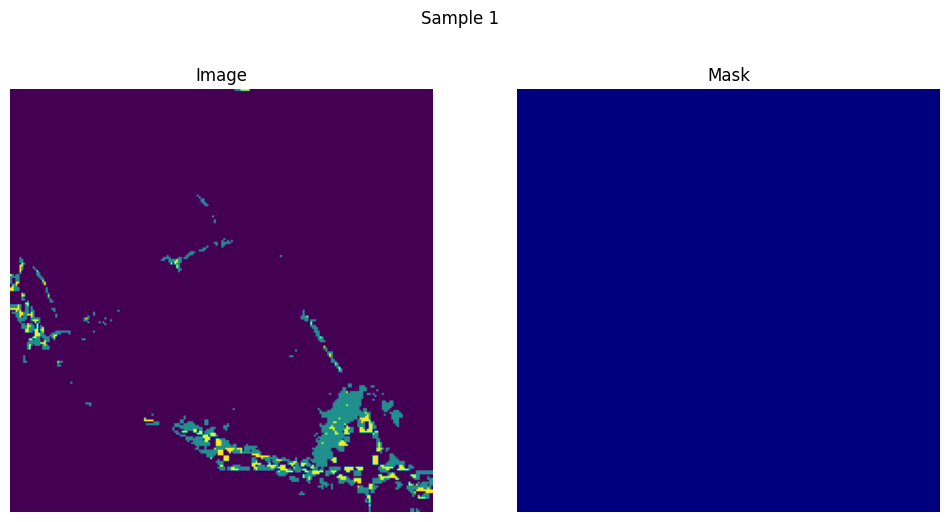

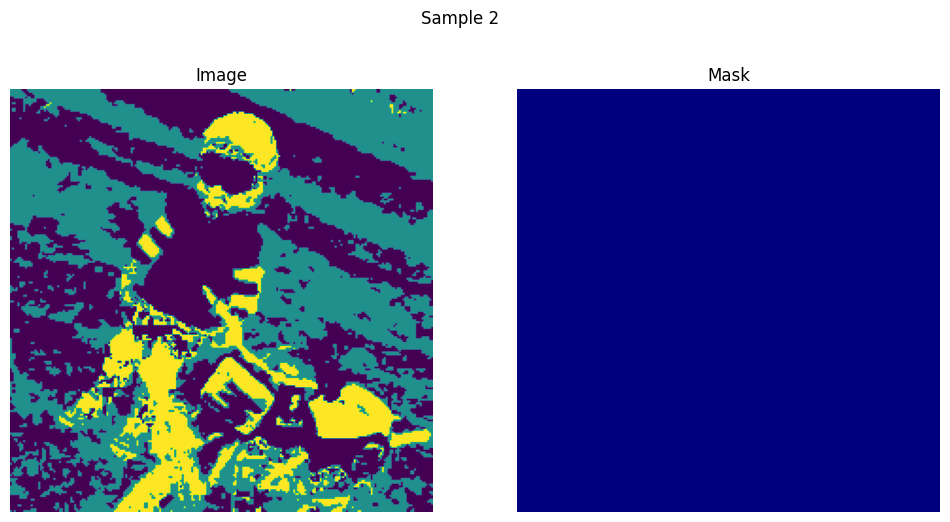

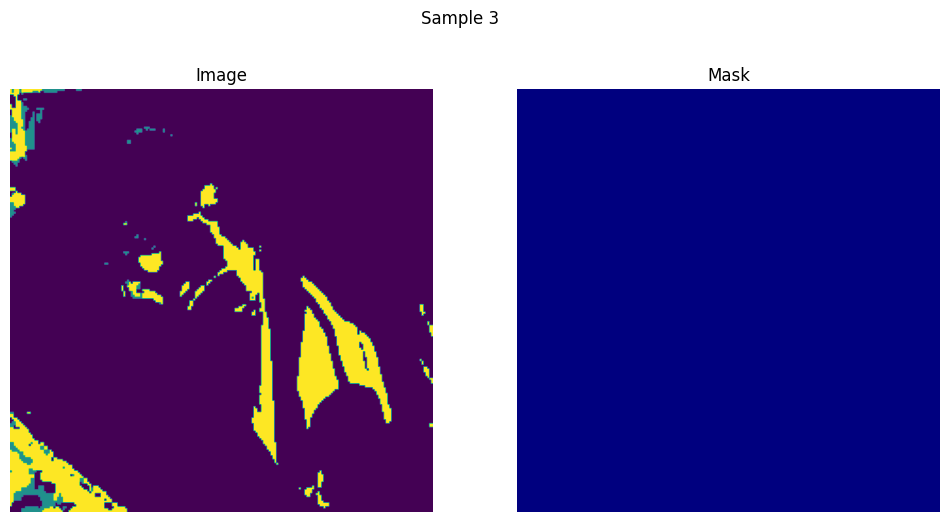

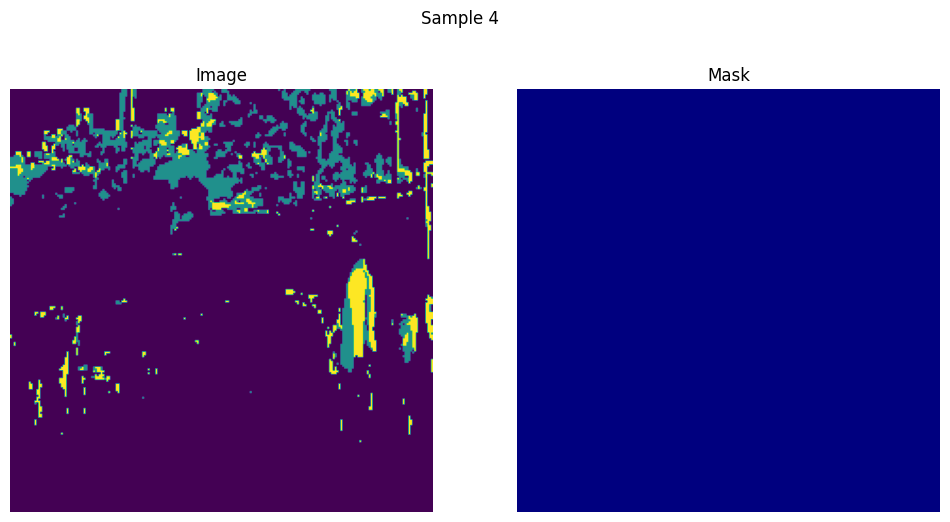

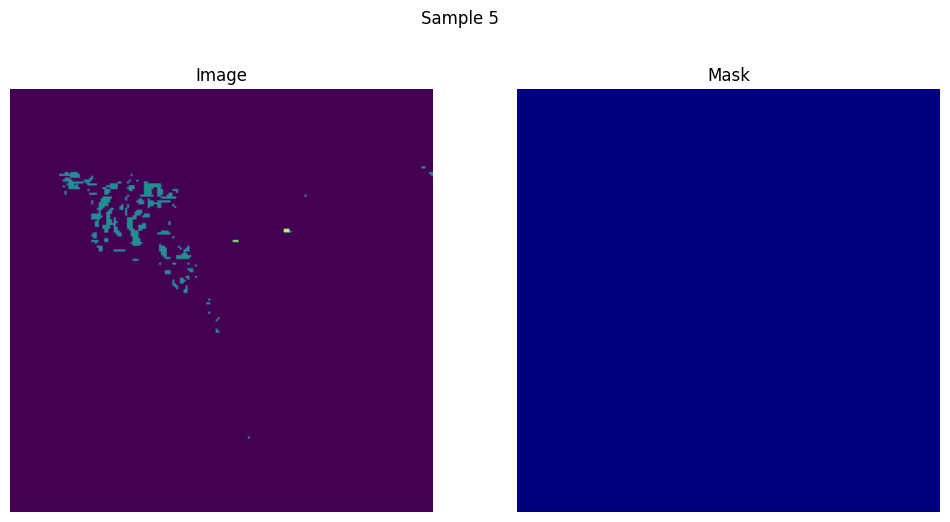

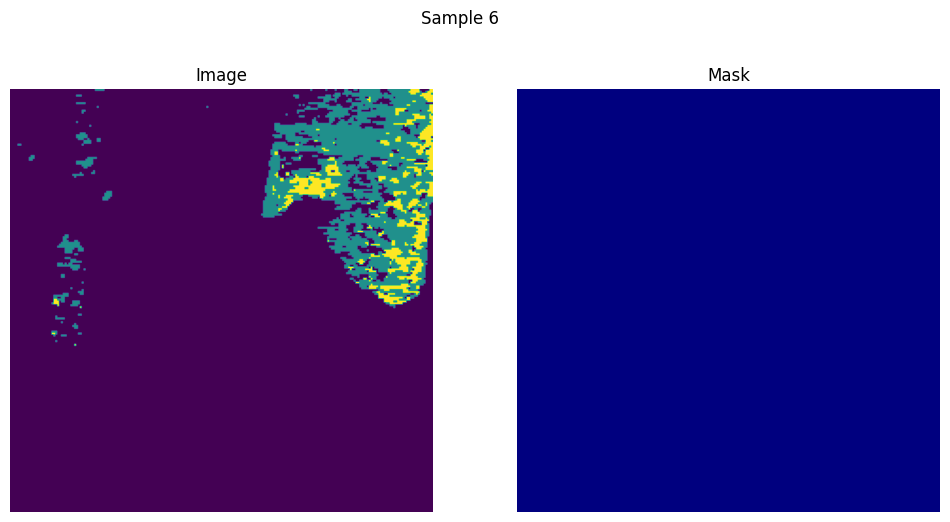

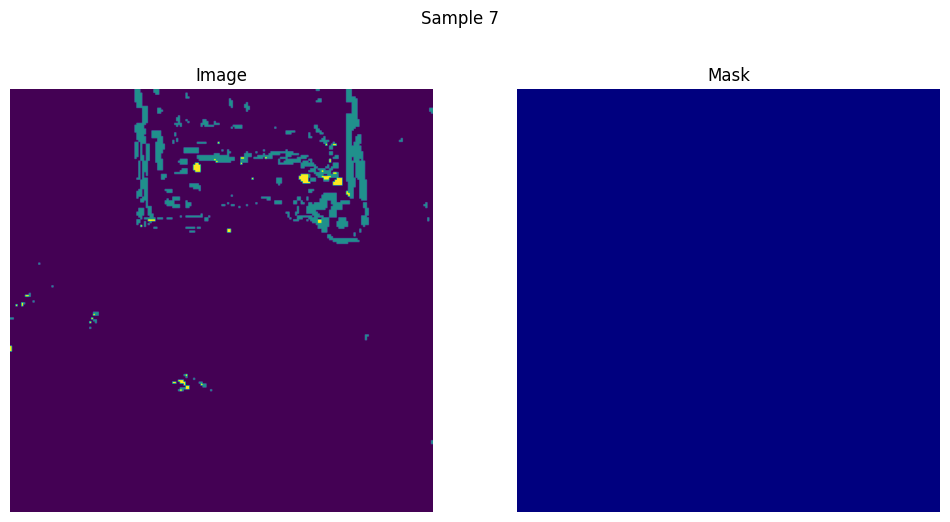

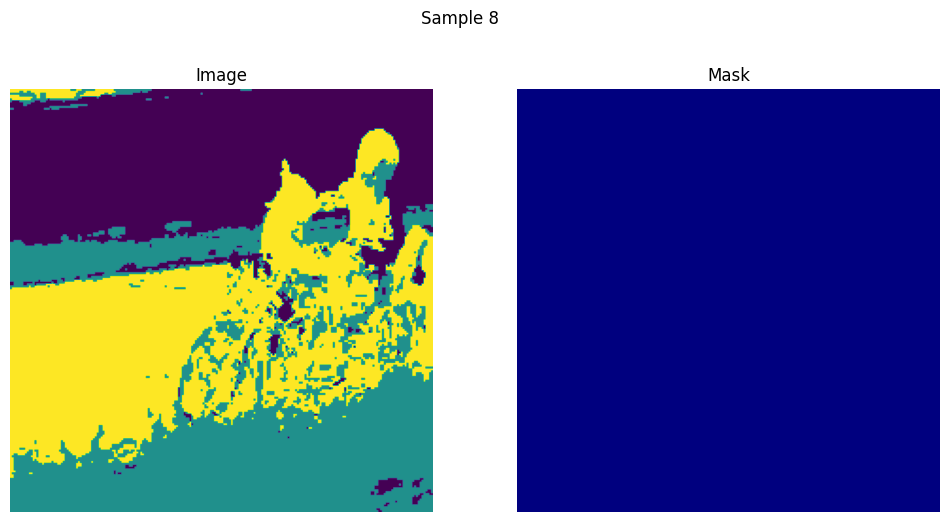

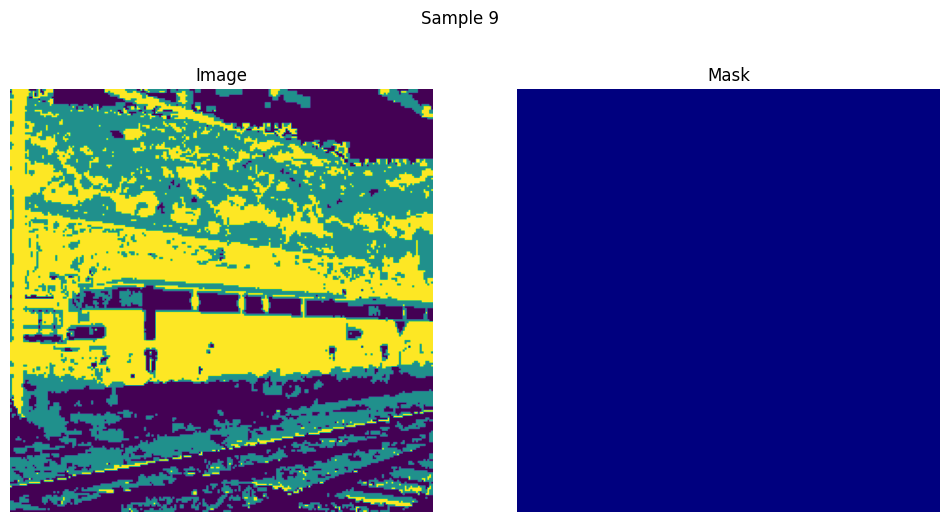

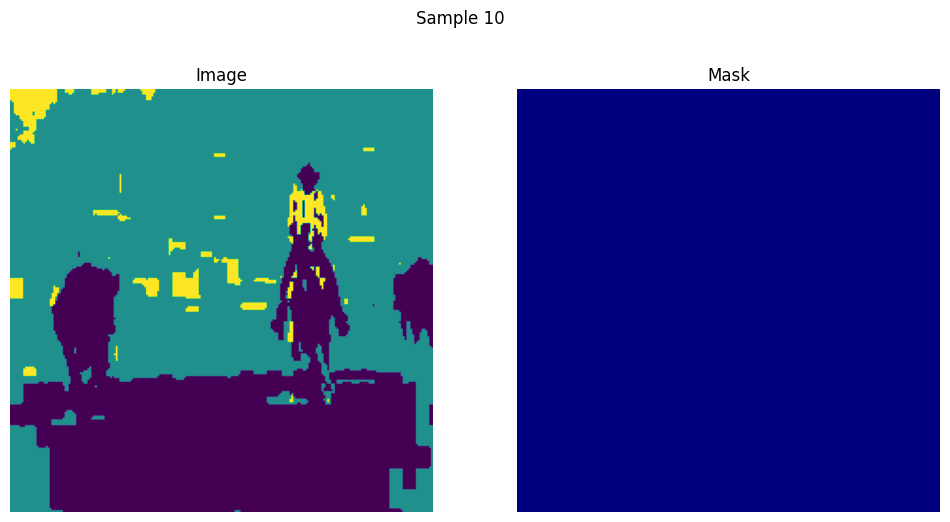

In [17]:
print(train_imgs.shape)
print(train_masks.shape)


import matplotlib.pyplot as plt
import numpy as np

def plot_sample(image, mask, title=""):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    if image.ndim == 3:  # Check if the mask is one-hot encoded
        image = np.argmax(image, axis=-1)  # Convert one-hot encoded mask to single-channel

    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    if mask.ndim == 3:  # Check if the mask is one-hot encoded
        mask = np.argmax(mask, axis=-1)  # Convert one-hot encoded mask to single-channel
    plt.imshow(mask, cmap='jet')  # Using 'jet' to provide distinct colors to different classes
    plt.title('Mask')
    plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Assuming 'images' and 'masks' are your datasets
for i in range(10):  # Display first 5 pairs to check
    plot_sample(train_imgs[i], train_masks[i], title=f"Sample {i+1}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.keras.backend.clear_session()

# Define Dice loss function and coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def unet_model(input_size=(224, 224, 3), num_classes=22):
    inputs = Input(input_size)
    
    # Downward path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Upward path
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=[dice_coefficient])

    return model

# Initialize the U-Net model
model = unet_model()
model.summary()  # This will print the summary of the model without needing Graphviz

# Assume data preparation here (X_train, Y_train, X_val, Y_val)

# Training the model
history = model.fit(train_imgs, train_masks, validation_data=(val_imgs, val_masks), batch_size=8, epochs=50)

# Plot training and validation Dice loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

def conv_block(input_tensor, num_filters):
    """A block of two convolutional layers with ReLU activations and batch normalization."""
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(input_tensor, num_filters):
    """An encoder block with a convolution block followed by max pooling."""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """A decoder block with upsampling, concatenation, and a convolution block."""
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def unet_model(input_size=(224, 224, 3), num_classes=22):
    inputs = Input(input_size)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    
    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
model = unet_model()
model.summary()

# Training the model
history = model.fit(train_imgs, train_masks, validation_data=(val_imgs, val_masks), batch_size=8, epochs=50)

# Plot training and validation Dice loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
